In [229]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import copy

from pointcloud_tools import PointCloudCreator #, create_pcd_from_array, read_pcd, write_pcd

from skimage.util import img_as_float
from skimage.util import img_as_ubyte

In [230]:
POT_HEIGHT = {
    "A": 10,
    "B": 7,
    "C": 10,
    "D": 10,
}

SUBSTRATE_HIGH = {              # if base ground (orange) is measure at -1.15
    "A": 0.0,
    "B": 7.5,
    "C": 2.5,
    "D": 0,
}

SUBSTRATE_LOW = {               # if base ground (orange) is measure at -1.35
    "A": 0.0,
    "B": 6.5,
    "C": 1.3,
    "D": 0,
}

In [231]:
def threshold_image(img_in, thres):
    """
    Apply a threshold in an image and return the resulting image
    :param img_in: Input image
    :param thres: The treshold value in the range [0, 255]
    :return: Resulting image (unsigned byte) where background is 0 and foreground is 255
    """

    background = img_in < thres
    foreground = img_in > thres

    mask = img_in > thres

    return img_as_ubyte(mask)

In [232]:
# point to the data dir
current_folder = Path(".").resolve()
base_dir = current_folder.parent / "data"

## Data Loader

In [233]:
# point to the image files
image = "B_07ea549e"            #A_1a111b40 B_0328ab97 B_93dd57ad  D_b14ffae7

rgb_file = base_dir / "rgb" / f"{image}.png"
depth_file = base_dir / "depth" / f"{image}_depth.png"

## Visualization

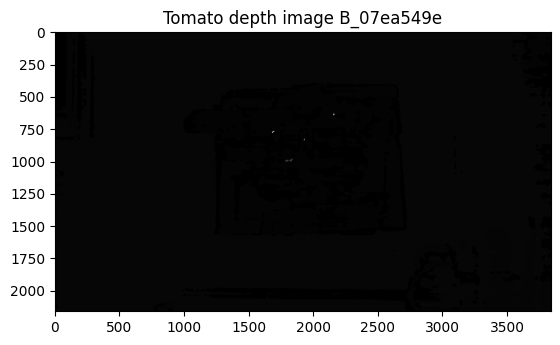

In [234]:
# The depth image is provided by the camera, and is a reconstruction from stero infra-red imaging.
depth_img = cv2.imread(str(depth_file), cv2.IMREAD_UNCHANGED)
plt.imshow(depth_img, cmap='gray')
plt.title(f"Tomato depth image {image}")
plt.show()

## Pointcloud Creator

In [235]:
# init a point cloud creator with the camera configuration
point_cloud_creator = PointCloudCreator(conf_file=base_dir / "oak-d-s2-poe_conf.json", logger_level=100)

# create pcd object
pcd_object = point_cloud_creator.convert_depth_to_pcd(rgb_file=rgb_file, depth_file=depth_file)

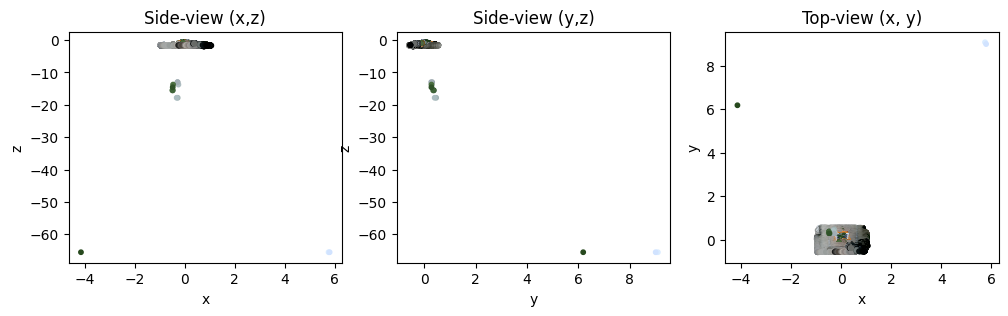

In [236]:
# Extract points and colors
points = np.asarray(pcd_object.points)
colors = np.asarray(pcd_object.colors)

# downsample to make the plotting faster

# use -y because the pixel coordinates differs from the matrix coordinate system
# use -z because the camera is facing downwards
x = copy.deepcopy(points[range(0, len(points), 100), 0])
y = copy.deepcopy(-points[range(0, len(points), 100), 1])
z = copy.deepcopy(-points[range(0, len(points), 100), 2]) 
c = copy.deepcopy(colors[range(0, len(points), 100), :])

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x, z, c=c, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y, z, c=c, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x, y, c=c, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()

In [237]:
ground_level = -1.4

# filter out the points that are below the ground level
mask = z > ground_level

x_ground_filtered = x[mask]
y_ground_filtered = y[mask]
z_ground_filtered = z[mask]
c_ground_filtered = c[mask]

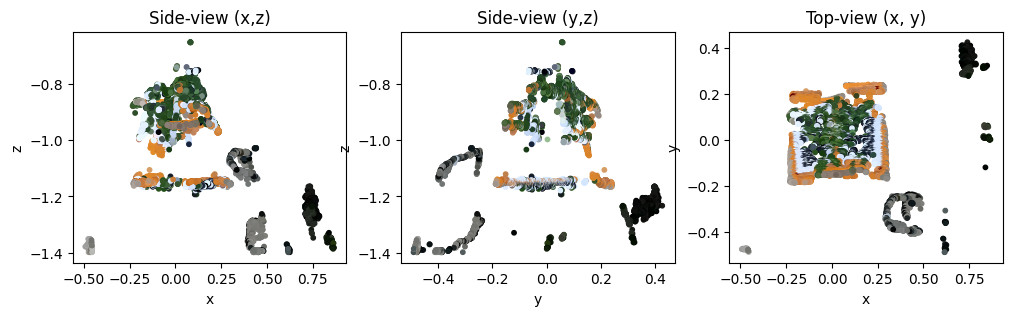

Minimum x position: -0.5604461496986999
Maximum x position: 0.9341887874898835
Minimum z position: -1.4352500021457673
Maximum z position: -0.6157499969005584
X range: 1.4946349371885834
Z range: 0.8195000052452088



In [238]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x_ground_filtered, z_ground_filtered, c=c_ground_filtered, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y_ground_filtered, z_ground_filtered, c=c_ground_filtered, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x_ground_filtered, y_ground_filtered, c=c_ground_filtered, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()


x_min, x_max = axs[0].get_xlim()
z_min, z_max = axs[0].get_ylim()
x_range = np.abs(x_max) + np.abs(x_min)
z_range = z_max - z_min
print(f"Minimum x position: {x_min}")
print(f"Maximum x position: {x_max}")
print(f"Minimum z position: {z_min}")
print(f"Maximum z position: {z_max}")
print(f"X range: {x_range}")
print(f"Z range: {z_range}")
print()

plant_max = np.max(z_ground_filtered)

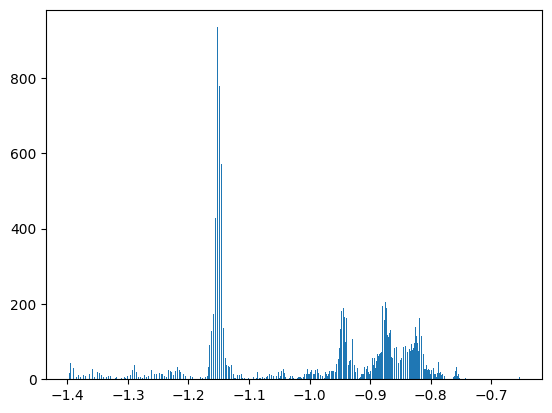

Ground level: 16
Ground level: -1.1521500003337861
Plant top0: -0.7572999978065491
Plant height: 0.324850002527237


In [239]:
freq, bins = np.histogram(z_ground_filtered, bins=300)
plt.hist(z_ground_filtered, bins=500)
plt.show()

mask = freq > 20
freq = freq[mask]
bins = bins[:-1][mask]

ground_y = np.argmax(freq)          #indize of the most frequent value
print(f"Ground level: {ground_y}")
ground_z = bins[ground_y]
print(f"Ground level: {ground_z}")

plant_top = np.max(bins)
print(f"Plant top0: {plant_top}")

pot_height = POT_HEIGHT[image[0]]

plant_height = plant_top - ground_z - pot_height/100
print(f"Plant height: {plant_height}")

In [240]:
z_only_ground = z_ground_filtered[z_ground_filtered < -1.1]


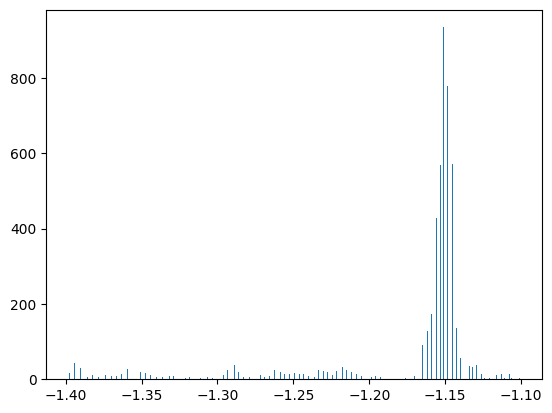

In [241]:
freq, bins = np.histogram(z_only_ground, bins=300)
plt.hist(z_only_ground, bins=500)
plt.show()

In [242]:
ground_y = np.argmax(freq)          #indize of the most frequent value
print(f"Ground level: {ground_y}")
ground_z = bins[ground_y]
print(f"Ground level: {ground_z}")

Ground level: 249
Ground level: -1.1514899599552155


In [243]:
pot_height = POT_HEIGHT[image[0]]

if ground_z < -1.25:
    substrat = SUBSTRATE_LOW[image[0]]
else:
    substrat = SUBSTRATE_HIGH[image[0]]

plant_height = plant_top - ground_z - pot_height/100 - substrat/100
print(f"Plant height: {plant_height}")

Plant height: 0.2491899621486664
